In [1]:
import librosa

In [2]:
import librosa.display

In [23]:
import os 
import math
import json 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf 
from tensorflow.keras.layers import Flatten , Dense
from tensorflow.keras.optimizers import Adam , RMSprop

In [10]:

DATASET_PATH = './genres_original/'
JSON_PATH = "data.json"
SAMPLE_RATE =22050 
DURATION= 30 #in second 
SAMPLES_PER_TRACK =  SAMPLE_RATE*DURATION


def save_mfcc(dataset_path , json_path , n_mfcc=13 , n_fft=2048, hop_length=512 , num_segments=5):
    
    #Dictionnary to store data 
    
    data = {
        "mapping":[] ,
        "mffc":[],
        "labels":[]
    } 
    
    num_samples_per_segment =  int(SAMPLES_PER_TRACK /num_segments)
    expected_num_mfcc_vectors_per_segment = math.ceil(num_samples_per_segment /hop_length)
     
    
    
    # Loop trough all genres 
    for i , (dirpath,dirnames,filenames )  in  enumerate(os.walk(dataset_path)):
        # ensure that we re not at the root level 
        
        if dirpath is not dataset_path:
            
            dirpath_components =dirpath.split("/")
            semantic_label = dirpath_components[-1]
            data["mapping"].append(semantic_label) 
            print("\nProcessing {}".format(semantic_label))
            
            #Process for files for  a specific genre 
            
            for f in filenames:
                file_path = os.path.join(dirpath ,f)
                signal , sr  = librosa.load(file_path , sr = SAMPLE_RATE) 
                
                #Process segments extracting mffcs and store the data 
                
                for s in range (num_segments):
                    start_sample = num_samples_per_segment *s
                    finish_sample = start_sample + num_samples_per_segment 
                    
                    #store mffc for segment if it has the expected  length 
                  
                    mffc =  librosa.feature.mfcc(signal[start_sample :finish_sample] ,
                                                  sr =sr , 
                                                  n_fft= n_fft ,
                                                  n_mfcc= n_mfcc , 
                                                  hop_length=hop_length) 
                    mffc = mffc.T
                    
                    if len(mffc) == expected_num_mfcc_vectors_per_segment:
                        data["mffc"].append(mffc.tolist())
                        data["labels"].append(i-1)
                        print("{} segment {}".format(file_path , s))
                        
    with open(json_path , "w") as fp :
        json.dump(data , fp , indent=4)

In [13]:
save_mfcc(DATASET_PATH ,JSON_PATH , num_segments=10)


Processing blues
./genres_original/blues\blues.00000.wav segment 0
./genres_original/blues\blues.00000.wav segment 1
./genres_original/blues\blues.00000.wav segment 2
./genres_original/blues\blues.00000.wav segment 3
./genres_original/blues\blues.00000.wav segment 4
./genres_original/blues\blues.00000.wav segment 5
./genres_original/blues\blues.00000.wav segment 6
./genres_original/blues\blues.00000.wav segment 7
./genres_original/blues\blues.00000.wav segment 8
./genres_original/blues\blues.00000.wav segment 9
./genres_original/blues\blues.00001.wav segment 0
./genres_original/blues\blues.00001.wav segment 1
./genres_original/blues\blues.00001.wav segment 2
./genres_original/blues\blues.00001.wav segment 3
./genres_original/blues\blues.00001.wav segment 4
./genres_original/blues\blues.00001.wav segment 5
./genres_original/blues\blues.00001.wav segment 6
./genres_original/blues\blues.00001.wav segment 7
./genres_original/blues\blues.00001.wav segment 8
./genres_original/blues\blues.00

In [15]:
dataset_path = "data.json"

def load_data(file=dataset_path):
    
    with open(file, 'r') as fp:
        data =  json.load(fp)
        
        inputs = np.array(data["mffc"])
        targets = np.array(data["labels"])
        
    return inputs , targets
 

In [17]:
inputs , targets = load_data()

In [18]:
inputs_train , inputs_test , targets_train , targets_test =  train_test_split(inputs , targets , test_size=0.3)

In [28]:
#Here We build the model 

model = tf.keras.models.Sequential([
    Flatten(input_shape=(inputs.shape[1] , inputs.shape[2])) ,
    Dense(512 , activation ="relu") ,
    Dense(256 , activation ="relu") ,
    Dense(64 , activation="relu") ,
    Dense(10 , activation="softmax")
    
])

model.compile(loss ="sparse_categorical_crossentropy" , optimizer =Adam(learning_rate=0.001) , metrics =["accuracy"] ) 

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 1690)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               865792    
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_10 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_11 (Dense)             (None, 10)                650       
Total params: 1,014,218
Trainable params: 1,014,218
Non-trainable params: 0
_________________________________________________________________


In [29]:
history=model.fit(inputs_train , targets_train , epochs=12 , validation_data = (inputs_test , targets_test) , batch_size=32)

Epoch 1/12
25/25 [==============================] - 1s 27ms/step - loss: 40.7069 - accuracy: 0.2341 - val_loss: 7.5684 - val_accuracy: 0.4848
Epoch 2/12
25/25 [==============================] - 0s 18ms/step - loss: 8.6480 - accuracy: 0.4304 - val_loss: 16.2184 - val_accuracy: 0.3333
Epoch 3/12
25/25 [==============================] - 0s 16ms/step - loss: 8.3479 - accuracy: 0.4564 - val_loss: 6.2376 - val_accuracy: 0.5455
Epoch 4/12
25/25 [==============================] - 0s 18ms/step - loss: 3.2538 - accuracy: 0.5969 - val_loss: 2.3905 - val_accuracy: 0.5333
Epoch 5/12
25/25 [==============================] - 0s 17ms/step - loss: 2.0941 - accuracy: 0.6320 - val_loss: 3.9625 - val_accuracy: 0.5697
Epoch 6/12
25/25 [==============================] - 0s 19ms/step - loss: 2.0530 - accuracy: 0.6541 - val_loss: 2.6393 - val_accuracy: 0.5879
Epoch 7/12
25/25 [==============================] - 0s 16ms/step - loss: 0.8203 - accuracy: 0.8023 - val_loss: 1.6429 - val_accuracy: 0.6909
Epoch 8/12


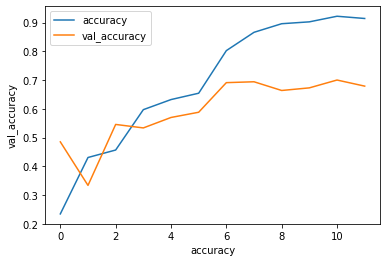

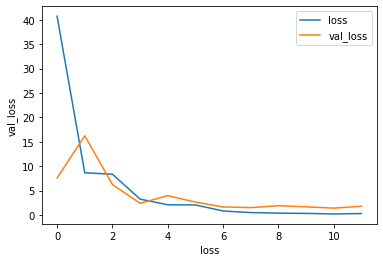

In [30]:
def plot_graph(history , string):
  plt.plot(history.history[string])
  plt.plot(history.history["val_"+string])
  plt.xlabel(string)
  plt.ylabel("val_"+string)
  plt.legend([string , "val_"+string])
  plt.show()

plot_graph(history , "accuracy")
plot_graph(history , "loss")

